## DSGA 1001 - Tree Analysis (Prediction)
### December 16, 2022
Code by: Yichen Shi

In [2]:
import pandas as pd
import numpy as np 
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency
from scipy.stats import ks_2samp
sns.set()
warnings.filterwarnings("ignore")

In [3]:
# seed the random number generator
np.random.seed(18962882)

In [2]:
# I alreadly cleaned the following datasets and saved in local
# original tree data: "2015_Street_Tree_Census_-_Tree_Data.csv"
# original demographic data: CDC SVI Documentation 2016, 'NewYork.csv'

# master is the combination of tree and demographic datasets
master =  pd.read_csv("master.csv")
# aggregated master 
data = pd.read_csv("tree_demo.csv")

In [4]:
# the tree data 
print(master.shape)
master.head(5)

(620896, 49)


,tree_id,block_id,created_at,tree_dbh,curb_loc,status,health,spc_latin,spc_common,steward,...,y_sp,AREA_SQMI,FIPS,EP_POV,EP_UNEMP,EP_PCI,EP_NOHSDP,EP_AGE65,EP_AGE17,EP_SNGPNT
0,180683,348711,08/27/2015,3,OnCurb,Alive,Fair,Acer rubrum,red maple,None,...,202756.7687,0.0866,36081073900,6.6,4.6,51560.0,5.1,19.1,19.9,6.4
1,179127,348611,08/27/2015,32,OnCurb,Alive,Good,Liriodendron tulipifera,tulip-poplar,None,...,201995.3874,0.0866,36081073900,6.6,4.6,51560.0,5.1,19.1,19.9,6.4
2,180699,348714,08/27/2015,21,OnCurb,Alive,Fair,Gleditsia triacanthos var. inermis,honeylocust,None,...,202766.5299,0.0866,36081073900,6.6,4.6,51560.0,5.1,19.1,19.9,6.4
3,180679,348711,08/27/2015,3,OnCurb,Alive,Good,Pyrus calleryana,Callery pear,None,...,202807.0075,0.0866,36081073900,6.6,4.6,51560.0,5.1,19.1,19.9,6.4
4,179181,348542,08/27/2015,7,OnCurb,Alive,Good,Acer platanoides,Norway maple,None,...,201953.2858,0.0866,36081073900,6.6,4.6,51560.0,5.1,19.1,19.9,6.4


In [3]:
# the aggregated data has 1684 rows
print(data.shape)
data.head(5)

(1684, 15)


,boro_ct,tree_count,percent_oncurb,percent_goodhealth,percent_fairhealth,percent_poorhealth,num_species,percent_damaged,EP_POV,EP_UNEMP,EP_PCI,EP_NOHSDP,EP_AGE65,EP_AGE17,EP_SNGPNT
0,1000600,164,90.853659,75.609756,17.682927,6.707317,24,14.024390,39.3,10.7,14554.0,49.8,26.3,17.9,7.7
1,1001402,123,99.186992,52.845528,37.398374,9.756098,22,18.699187,29.1,3.1,35518.0,25.3,14.9,8.5,3.6
2,1001600,269,86.617100,78.810409,16.728625,4.460967,25,12.267658,33.4,3.5,28665.0,37.9,21.0,14.1,2.2
3,1001800,301,80.730897,84.053156,13.621262,2.325581,32,10.299003,25.2,6.4,35524.0,30.4,12.7,8.1,1.9
4,1002201,112,97.321429,77.678571,12.500000,9.821429,23,10.714286,29.1,13.9,26508.0,18.8,13.9,9.3,7.9


---
Some data description (what I'm interested) | Meaning
---|---|
block_id| census track for each borough, the first number is in the range of (1,5), denotes each borough
curb_loc|location of tree bed in relationship to the curb, either 'along the curb' or 'offset from the curb'
status|the status of each tree, alive, dead or steward.
spc_common|the tree species, has hundreds categories
health| the tree health has 3 categories, 'Good, Fair, Poor'
sidewalk|whether there's sidewalk damage, either 'damage' or 'no damage'
latitude and longitude|the location of each tree

# Inference questions
I'm interested in two parts. First, for the tree dataset alone, what's the indicators for the tree health? I'll do some inference questions related to the tree health, curb_location and sidewalk damage. Second, adding the demographic dataset, does different demographic groups show different tree statistics (i.e. tree counts)? I'll draw graphs to visualize the results and use hypothesis test to verfiy.

## 1. Is there any evidence of a relatonship between the curb_location and sidewalk damage?
- test used: chi-sqaure test, since the two variables are categorical
- Assumptions: 1. the categories are indpt and mutually exclusive  2. All expected values at least 5
- Hypothesis:
    H0: there's no relationship between curb_loc and sidewalk damage (indpt), H1: there's a relationship between the two variables (not indpt)
- significance level: 0.05, df =  (# rows -1) *(#columns-1)

In [5]:
# variables interested 
print(master['curb_loc'].unique())
print(master['sidewalk'].unique())

['OnCurb' 'OffsetFromCurb']
['NoDamage' 'Damage']


In [6]:
curb_damage = master[['curb_loc','sidewalk']]
# create a contingency table for chi-sqaure test 
# get the counts pertaining to each category
ct = pd.crosstab(master['curb_loc'], master['sidewalk'])

In [7]:
# calculate the expected values
pd.crosstab(master['curb_loc'],master['sidewalk'], margins=True)

sidewalk,Damage,NoDamage,All
curb_loc,,,
OffsetFromCurb,3197,19752,22949
OnCurb,175411,422536,597947
All,178608,442288,620896


In [8]:
# compute the expected values for each cell 
#E_offset_damage= 22949*178608/620896
#E_offset_nodamage = 22949*442288/620896
#E_oncurb_damage = 597947*178608/620896
# E_oncurb_nodamage= 597947*442288/620896
# all expected values are at least 5, the assumption 2 has been met

In [9]:
chi_val, p_val, dof, expected =  chi2_contingency(ct)
print("chisquare-score is:", chi_val, " Df is:",dof, "P-value is:", p_val)

chisquare-score is: 2558.6773011517153  Df is: 1 P-value is: 0.0


In [10]:
print('The curb location and side walk damage are not independent.')

The curb location and side walk damage are not independent.


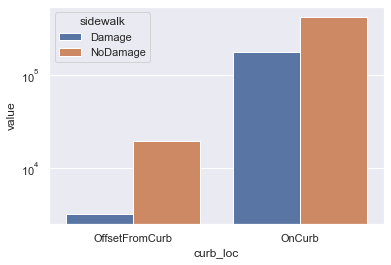

In [11]:
# histogram of proportion of sidewalk damge on curb vs prop of damage offset from curb
stacked = ct.stack().reset_index().rename(columns={0:'value'})
g= sns.barplot(x=stacked.curb_loc, y=stacked.value, hue=stacked.sidewalk)
g.set_yscale("log")

with a large sample size statistical power is high and the probability of rejecting the null hypothesis is high, even if the relationship is relatively weak. In addition to examining statistical significance by looking at the p value, we can also examine practical significance by computing the relative risk

In [12]:
# examining practical significance by computing relative risk
# risk of damage pertaining curb_loc
r_on = 175411/(175411+422536)
r_off= 3197/(3197+19752)
r_on/r_off
print('On_curb trees are', round(r_on/r_off,2), 'times more likely to have sidewalk damage.')

On_curb trees are 2.11 times more likely to have sidewalk damage.


## 1.1 What's the relationship between tree health and  curb locations? 

In [13]:
print(master['health'].value_counts())
print(master['curb_loc'].value_counts())

Good    504181
Fair     91293
Poor     25422
Name: health, dtype: int64
OnCurb            597947
OffsetFromCurb     22949
Name: curb_loc, dtype: int64


In [14]:
# since the samplesfor fair and poor are much less than good, here I combine those two categories into one
# 'not good' category
new = master.copy()
new['health'] = np.where(new['health'] =='Good', 'Good', 'Not Good')

In [15]:
ct = pd.crosstab(new['curb_loc'],new['health'])
chi_val, p_val, dof, expected =  chi2_contingency(ct)
print("chisquare-score is:", round(chi_val,2), " Df is:",dof, "P-value is:",round(p_val,2) )

chisquare-score is: 14.95  Df is: 1 P-value is: 0.0


In [16]:
ct

health,Good,Not Good
curb_loc,,
OffsetFromCurb,18410,4539
OnCurb,485771,112176


In [17]:
# the relative risk for offcurb trees exhibit good health vs on curb trees exhibit good health
r_off = 18410/(18410+4539)
r_on= 485771/(485771+112176)
r= round(r_off/r_on,2)
print('The relative risk for offcurb trees exhibit good health vs on curb trees exhibit good health is',r)

The relative risk for offcurb trees exhibit good health vs on curb trees exhibit good health is 0.99


In [18]:
# Though the test statistic is strong, there's almost no practical effect.
# The significant test score might be due to the large sample sizes
# With a large enough sample, even trivial relationships can appear to be statistically significant

## 1.2  What's the relationship between the tree health and curb locations conditioned on the sidewalk damage?

In [19]:
# conditioned on no sidewalk damage trees
new2 = new[new['sidewalk']=="NoDamage"]
ct = pd.crosstab(new2['curb_loc'],
                            new2['health'])
chi_val, p_val, dof, expected =  chi2_contingency(ct)
print("chisquare-score is:", chi_val, " Df is:",dof, "P-value is:", p_val)

chisquare-score is: 0.22818082508519621  Df is: 1 P-value is: 0.6328760122575435


In [20]:
print('There is no evidence to conclude there\'s a relationship between these two variables',
      'when conditioned on no sidewalk damage')

There no evidence to conclude there's a relationship between these two variables when conditioned on no sidewalk damage


In [21]:
# curb_loc vs health on no sidewalk damage trees
new2 = new[new['sidewalk']=="Damage"]
ct = pd.crosstab(new2['curb_loc'],new2['health'])
print(ct)
chi_val, p_val, dof, expected =  chi2_contingency(ct)
print("chisquare-score is:", chi_val, " Df is:",dof, "P-value is:", p_val)

health            Good  Not Good
curb_loc                        
OffsetFromCurb    2401       796
OnCurb          142720     32691
chisquare-score is: 80.39784543200562  Df is: 1 P-value is: 3.06128817484238e-19


In [22]:
r_off = 796/(2401+796)
r_on= 32691/(142720+32691)
# the relative risk having not good tree health for on curb and off curb trees conditioned on sidewalk damage
r_off/r_on

1.3359772117429805

In [23]:
# again though the test statistic is significant, the practical efffect is not strong, therefore, can't conclude 
# there's a relationship

## 2.  What's the relationship between tree statistics and demographic factors?
To investigate the relationship between tree data and demographic factors, I use the aggregated data.The tree data and demographic data are combined according to the 'boro_ct' feature, which is the census track in each borough that the tree point falls into. Then, I aggregate the data and calculate the counts or percentage for each variable in the distinct boro_ct. All the percentages arein % units. 

In [24]:
data.head(5)

,boro_ct,tree_count,percent_oncurb,percent_goodhealth,percent_fairhealth,percent_poorhealth,num_species,percent_damaged,EP_POV,EP_UNEMP,EP_PCI,EP_NOHSDP,EP_AGE65,EP_AGE17,EP_SNGPNT
0,1000600,164,90.853659,75.609756,17.682927,6.707317,24,14.024390,39.3,10.7,14554.0,49.8,26.3,17.9,7.7
1,1001402,123,99.186992,52.845528,37.398374,9.756098,22,18.699187,29.1,3.1,35518.0,25.3,14.9,8.5,3.6
2,1001600,269,86.617100,78.810409,16.728625,4.460967,25,12.267658,33.4,3.5,28665.0,37.9,21.0,14.1,2.2
3,1001800,301,80.730897,84.053156,13.621262,2.325581,32,10.299003,25.2,6.4,35524.0,30.4,12.7,8.1,1.9
4,1002201,112,97.321429,77.678571,12.500000,9.821429,23,10.714286,29.1,13.9,26508.0,18.8,13.9,9.3,7.9


---
Demographic Variables | Meaning
---|---|
EP_POV|percentage of persons below poverty estimate
EP_UNEMP| percentage of civilian (age 16+) unemployed estimate
EP_PCI| Per capita income estimate
EP_NOHSDP|Percentage of persons with no high school diploma (age 25+) estimate
EP_AGE65| Percentage of persons aged 65 and older estimate
EP_AGE17| Percentage of persons aged 17 and younger estimate
EP_SNGPNT| Percentage of single parent households with children under 18 estimate

In [25]:
demo = data.copy()
demo['id'] = range(0, len(demo))
# median split for demographic variables
demo["poverty"] = (data.EP_POV<data.EP_POV.quantile(0.5)).replace({True:0, False:1})
demo["unemployed"] = (data.EP_UNEMP<data.EP_UNEMP.quantile(0.5)).replace({True:0, False:1})
demo["nohighschool"] = (data.EP_NOHSDP<data.EP_NOHSDP.quantile(0.5)).replace({True:0, False:1})
demo["income"] = (data.EP_PCI<data.EP_PCI.quantile(0.5)).replace({True:0, False:1})
demo["above65"] = (data.EP_AGE65<data.EP_AGE65.quantile(0.5)).replace({True:0, False:1})
demo["singleparent"] = (data.EP_SNGPNT<data.EP_SNGPNT.quantile(0.5)).replace({True:0, False:1})

In [26]:
# tree_count (unit counts) vs demo 
demo3 = demo[['id','tree_count',"poverty","unemployed","nohighschool","income","above65","singleparent"]]
demo3 = demo3.melt(id_vars=["id",'tree_count'], var_name='demofactor')
demo3['value']=(demo3.value==0).replace({True:'below medium', False:'above medium'})
# num_species (unit counts) vs demo
demo4 = demo[['id','num_species',"poverty","unemployed","nohighschool","income","above65","singleparent"]]
demo4 = demo4.melt(id_vars=["id",'num_species'], var_name='demofactor')
demo4['value']=(demo4.value==0).replace({True:'below medium', False:'above medium'})

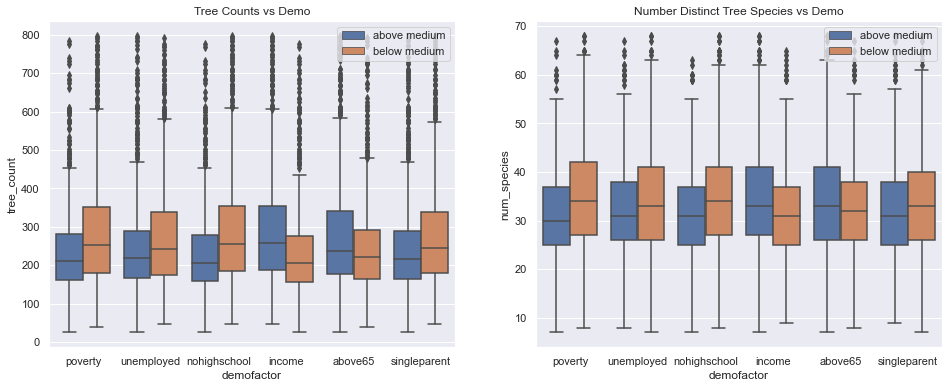

In [27]:
fig, ax = plt.subplots(1,2, figsize=(16,6)) 
sns.boxplot(x=demo3.demofactor, y=demo3.tree_count, hue=demo3.value,ax=ax[0]).set(title='Tree Counts vs Demo')
ax[0].legend(loc = 'upper right')
sns.boxplot(x=demo4.demofactor, y=demo4.num_species, hue=demo4.value,ax=ax[1]).set(title='Number Distinct Tree Species vs Demo')
ax[1].legend(loc = 'upper right')

**Test for tree counts/number species for the below median and above median groups for each of the 6 demo factors**
- test used: since the two groups are continuous, not normally distributed and exist lots of outliers, **Whitney U** test is more suitable here. 
- Assumptions: 1.random samples from the population 2. indpt within samples and mutual indpt 3. some ordinal scales
- Hypothesis:
    H0: The two samples come from population with the same median, H1: the two samples come from the different population with different medians
- significance level: 0.05

In [28]:
# record the p-value and u statistics for each of the demo factors
def u_test(factor):
    f,l,s,r = np.array([]),np.array([]),np.array([]),np.array([])
    a = ["poverty","unemployed","nohighschool","income","above65","singleparent"]
    for i in range(len(a)):
        u,p = stats.mannwhitneyu(demo[demo[a[i]]==0][factor],demo[demo[a[i]]==1][factor])
        if p<=0.05:
            r = np.append(r,'Yes')
        else:
            r = np.append(r,'No')
        l = np.append(l,round(u,2))
        s = np.append(s,round(p,2))
        f= np.append(f, a[i])
    u_df = pd.DataFrame({'Factor':f,'U score':l,'P-value':s,'Reject Null':r})
    return u_df

**Test reults**

In [36]:
print('U test to compare the trees counts for the below median factor group and above median factor group')
u_test('tree_count')

U test to compare the trees counts for the below median factor group and above median factor group


,Factor,U score,P-value,Reject Null
0,poverty,429815.5,0.0,Yes
1,unemployed,395200.0,0.0,Yes
2,nohighschool,441510.5,0.0,Yes
3,income,264329.0,0.0,Yes
4,above65,312315.0,0.0,Yes
5,singleparent,405548.5,0.0,Yes


In [37]:
print('U test to compare the number of species for the below median factor group and above median factor group')
u_test('num_species')

U test to compare the number of species for the below median factor group and above median factor group


,Factor,U score,P-value,Reject Null
0,poverty,422572.0,0.00,Yes
1,unemployed,390271.5,0.00,Yes
2,nohighschool,413106.0,0.00,Yes
3,income,301968.0,0.00,Yes
4,above65,328968.5,0.01,Yes
5,singleparent,384310.0,0.00,Yes


**Test for percentage of good/fair/poor tree health, percentage of damaged trees for the below median and above median groups for each of the 6 demo factors**
- test used: Since the two groups are percentages, it's not very meaningful to reduce to mean or medians. Thus **KS test** is used here to compare the distributions of the two groups instead.
- Assumptions: 1.random samples from the population 2. indpt within samples and mutual indpt 3. some ordinal scales
- Hypothesis:
    H0: The two samples have the same distribution, H1: the two samples have different distributions
- significance level: 0.05

In [43]:
def ks_test(factor):
    l,s,r = np.array([]),np.array([]),np.array([])
    a = ["poverty","unemployed","nohighschool","income","above65","singleparent"]
    for i in range(len(a)):
        # below median group
        g1 =  demo[demo[a[i]]==0][factor]
        # above median group
        g2 =  demo[demo[a[i]]==1][factor]
        k,p = ks_2samp(g1, g2)
        l = np.append(l,k)
        s = np.append(s,p)
        if p<=0.05:
            r = np.append(r,'Yes')
        else:
            r = np.append(r,'No')
    ks_df = pd.DataFrame({'ks_stats':l,'p_val':s,'Reject Null':r})
    return ks_df

**Results**

In [44]:
ks_test("percent_damaged")

,ks_stats,p_val,Reject Null
0,0.033010,0.729994,No
1,0.048061,0.272575,No
2,0.056717,0.126149,No
3,0.053444,0.180453,No
4,0.036866,0.597108,No
5,0.055819,0.145069,No


In [45]:
ks_test("percent_goodhealth")

,ks_stats,p_val,Reject Null
0,0.060868,0.083353,No
1,0.047833,0.277650,No
2,0.023420,0.968645,No
3,0.033254,0.740755,No
4,0.039004,0.525166,No
5,0.065321,0.055027,No


<Figure size 432x288 with 0 Axes>

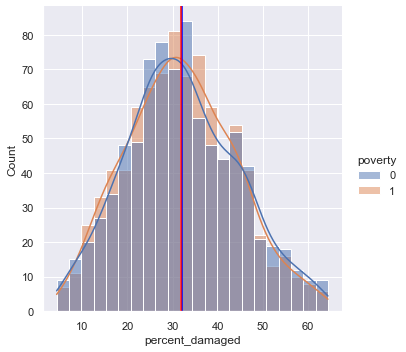

<Figure size 432x288 with 0 Axes>

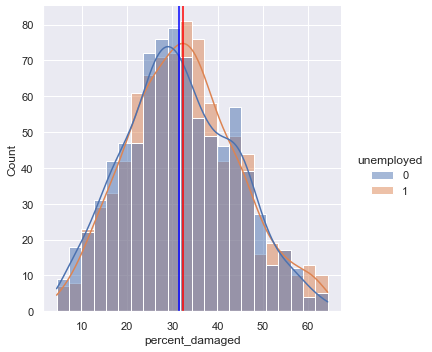

<Figure size 432x288 with 0 Axes>

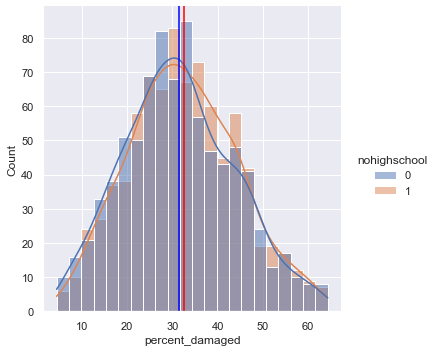

<Figure size 432x288 with 0 Axes>

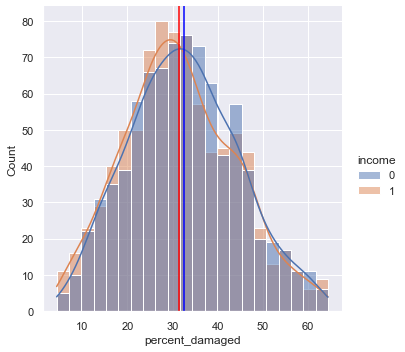

<Figure size 432x288 with 0 Axes>

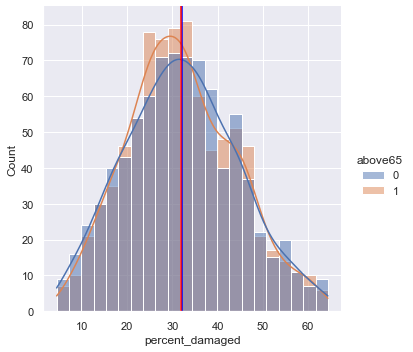

<Figure size 432x288 with 0 Axes>

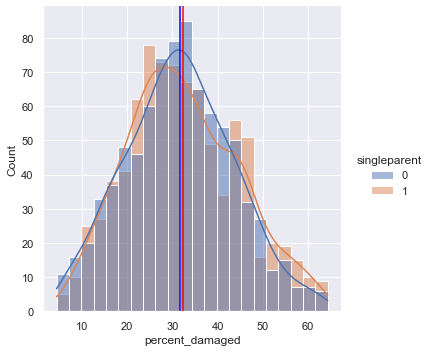

In [48]:
# As we can see, the distributions are almost the same
a = ["poverty","unemployed","nohighschool","income","above65","singleparent"]
for i in range(len(a)):
    plt.figure()
    p1 =np.mean(demo[demo[a[i]]==0]['percent_damaged'])
    p2 = np.mean(demo[demo[a[i]]==1]['percent_damaged'])
    sns.displot(x = demo['percent_damaged'],hue=demo[a[i]],kde = True,fill=True)
    plt.axvline(p1,color ='blue')
    plt.axvline(p2,color ='red')
    plt.show()

# Geo plot

In [49]:
import contextily as cx
import geopandas as gpd
from shapely.geometry import Point
import geopandas as gpd
import folium

In [50]:
df=master[['spc_common', 'tree_dbh', 'health', 'longitude', 'latitude']]

In [51]:
# transfer the dataframe to geodataframe
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
geo_df = gpd.GeoDataFrame(df, geometry=geometry, crs="epsg:4326")

In [52]:
geo_df.to_csv('geo_df.csv', index=False)

In [53]:
geo_sample = geo_df.sample(n=10000)

In [54]:
geo_sample.head(5)

,spc_common,tree_dbh,health,longitude,latitude,geometry
382875,green ash,25,Good,-74.119825,40.577528,POINT (-74.11982 40.57753)
601030,littleleaf linden,9,Good,-73.887569,40.736969,POINT (-73.88757 40.73697)
201276,Japanese zelkova,11,Good,-73.936759,40.670811,POINT (-73.93676 40.67081)
537919,Norway maple,14,Fair,-73.868838,40.681886,POINT (-73.86884 40.68189)
522269,honeylocust,10,Good,-73.889132,40.762852,POINT (-73.88913 40.76285)


In [55]:
# add borough boundaries to the geo map
boro = gpd.read_file('geo_export_f547bd6f-f469-41d3-ad98-8352fe49d49d.shp')

In [56]:
boro

,borocode,boroname,shape_area,shape_leng,geometry
0,5.0,Staten Island,1.623827e+09,330457.564664,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,3.0,Brooklyn,1.937582e+09,741176.424181,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ..."
2,1.0,Manhattan,6.365056e+08,360373.009632,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
3,4.0,Queens,3.045170e+09,897059.188795,"MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ..."
4,2.0,Bronx,1.186965e+09,464402.407188,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."


In [57]:
b = boro.explore(column ="boroname",cmap=['grey', 'salmon', 'orange', 'pink', 'tan'],name="borough")
m= geo_sample.explore(m = b, column="health", cmap=["red","green","blue"], name="tree health")
folium.LayerControl().add_to(m)

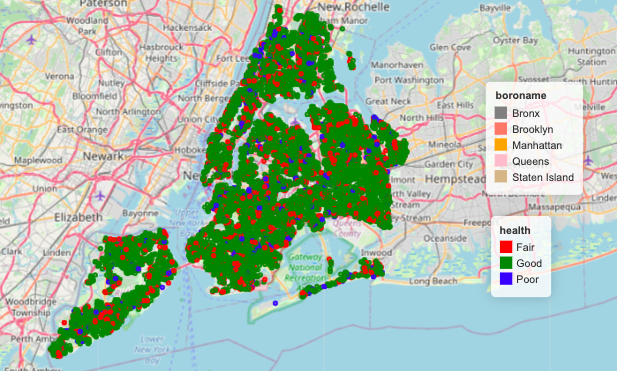

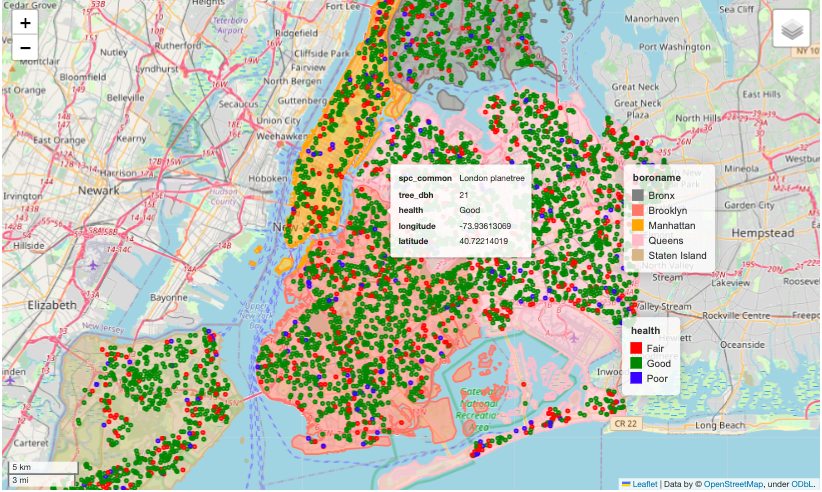